# 4 - Automate the fit tree ring center for all flat fields

Author: Johnny Esteves, University Of Michigan

### Description
In this notebook, you'll measure the tree ring center fit on super flat field images for the R02 S02 (ITL) and R22 S11 (e2v) sensors.



In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import fitsio as fits

import matplotlib.pyplot as plt
plt.rc('image', interpolation='bicubic', origin='lower', cmap = 'viridis')
plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams['figure.figsize'] = [14.0, 10.0]
plt.rcParams['font.size'] = 16
rcParams = plt.rcParams.copy()


import numpy as np

from scipy.stats import binned_statistic_2d, binned_statistic
from skimage.measure import block_reduce
from skimage.util import view_as_blocks
from scipy.ndimage.filters import gaussian_filter
import scipy.optimize as opt

In [2]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(obj=None, ax=None, size="5%", pad=0.1):
    should_restore = False

    if obj is not None:
        ax = obj.axes
    elif ax is None:
        ax = plt.gca()
        should_restore = True

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad)

    plt.colorbar(obj, cax=cax)

    if should_restore:
        plt.sca(ax)
        
def imshow(image, qq=[0.5,97.5], show_colorbar=True, **kwargs):
    vmin1,vmax1 = np.percentile(image[np.isfinite(image)], qq)
    if 'vmin' not in kwargs.keys():
        kwargs['vmin'] = vmin1
    if 'vmax' not in kwargs.keys():
        kwargs['vmax'] = vmax1
    plt.imshow(image, **kwargs)
    if show_colorbar:
        colorbar()

In [3]:
# 
import numpy
import scipy

def block_view(A, block_shape):
    """Provide a 2D block view of a 2D array.
    
    Returns a view with shape (n, m, a, b) for an input 2D array with
    shape (n*a, m*b) and block_shape of (a, b).
    """
    assert len(A.shape) == 2, '2D input array is required.'
    assert A.shape[0] % block_shape[0] == 0, 'Block shape[0] does not evenly divide array shape[0].'
    assert A.shape[1] % block_shape[1] == 0, 'Block shape[1] does not evenly divide array shape[1].'
    shape = np.array((A.shape[0] / block_shape[0], A.shape[1] / block_shape[1]) + block_shape).astype(int)
    strides = np.array((block_shape[0] * A.strides[0], block_shape[1] * A.strides[1]) + A.strides).astype(int)
    return numpy.lib.stride_tricks.as_strided(A, shape=shape, strides=strides)

def apply_filter(A, smoothing, power=2.0):
    """Apply a hi/lo pass filter to a 2D image.
    
    The value of smoothing specifies the cutoff wavelength in pixels,
    with a value >0 (<0) applying a hi-pass (lo-pass) filter. The
    lo- and hi-pass filters sum to one by construction.  The power
    parameter determines the sharpness of the filter, with higher
    values giving a sharper transition.
    """
    if smoothing == 0:
        return A
    ny, nx = A.shape
    # Round down dimensions to even values for rfft.
    # Any trimmed row or column will be unfiltered in the output.
    nx = 2 * (nx // 2)
    ny = 2 * (ny // 2)
    T = np.fft.rfft2(A[:ny, :nx])
    # Last axis (kx) uses rfft encoding.
    kx = np.fft.rfftfreq(nx)
    ky = np.fft.fftfreq(ny)
    kpow = (kx ** 2 + ky[:, np.newaxis] ** 2) ** (power / 2.)
    k0pow = (1. / smoothing) ** power
    if smoothing > 0:
        F = kpow / (k0pow + kpow) # high pass
    else:
        F = k0pow / (k0pow + kpow) # low pass
    S = A.copy()
    S[:ny, :nx] = np.fft.irfft2(T * F)
    return S

def zero_by_region(data, region_shape, num_sigmas_clip=4.0, smoothing=250, power=4):
    """Subtract the clipped median signal in each amplifier region.
    
    Optionally also remove any smooth variation in the mean signal with
    a high-pass filter controlled by the smoothing and power parameters.
    Returns a an array of median levels in each region and a mask of
    unclipped pixels.
    """
    mask = np.zeros_like(data, dtype=bool)

    # Loop over amplifier regions.
    regions = block_view(data, region_shape)
    masks   = block_view(mask, region_shape)
    ny, nx = regions.shape[:2]
    levels = np.empty((ny, nx))
  
    for y in range(ny):
        for x in range(nx):
            region_data = regions[y, x]
            region_mask = masks[y, x]
            clipped1d, lo, hi = scipy.stats.sigmaclip(
                region_data, num_sigmas_clip, num_sigmas_clip)
            # Add unclipped pixels to the mask.
            region_mask[(region_data > lo) & (region_data < hi)] = True            
            # Subtract the clipped median in place.
            levels[y, x] = np.median(clipped1d)
            region_data -= levels[y, x]
            # Smooth this region's data.
            if smoothing != 0:
                clipped_data = region_data[~region_mask]
                region_data[~region_mask] = 0.
                region_data[:] = apply_filter(region_data, smoothing, power)
                region_data[~region_mask] = clipped_data
                
    return levels, mask
def get_diff_lowpass(image, size=250, power=4.0, use_zero=True, geometry=(2,8)):
    if use_zero:
        image1 = image.copy()
        levels,mask = zero_by_region(image1, (image1.shape[0]/geometry[0], image1.shape[1]/geometry[1]))

        return image1/image
    else:
        diff = apply_filter(image, size, power=power)
    
        return diff/image

In [4]:
import numpy as np
import lsst.eotest.image_utils as imutils
import lsst.afw.image as afwImage
from lsst.eotest.sensor.MaskedCCD import MaskedCCD
from lsst.eotest.sensor.AmplifierGeometry import parse_geom_kwd

def make_ccd_mosaic(infile, bias_frame=None, gains=None, fit_order=1,dm_view=False):
    """Combine amplifier image arrays into a single mosaic CCD image array."""
    ccd = MaskedCCD(infile, bias_frame=bias_frame)
    datasec = parse_geom_kwd(ccd.amp_geom[1]['DATASEC'])
    nx_segments = 8
    ny_segments = 2
    nx = nx_segments*(datasec['xmax'] - datasec['xmin'] + 1)
    ny = ny_segments*(datasec['ymax'] - datasec['ymin'] + 1)
    mosaic = np.zeros((ny, nx), dtype=np.float32) # this array has [0,0] in the upper right corner on LCA-13381 view o
     
    for ypos in range(ny_segments):
        for xpos in range(nx_segments):
            amp = ypos*nx_segments + xpos + 1      
            detsec = parse_geom_kwd(ccd.amp_geom[amp]['DETSEC'])
            xmin = nx - max(detsec['xmin'], detsec['xmax'])
            xmax = nx - min(detsec['xmin'], detsec['xmax']) + 1
            ymin = ny - max(detsec['ymin'], detsec['ymax'])
            ymax = ny - min(detsec['ymin'], detsec['ymax']) + 1
            #
            # Extract bias-subtracted image for this segment - overscan not corrected, since we don't pass overscan he
            #
            segment_image = ccd.unbiased_and_trimmed_image(amp, fit_order=fit_order)
            subarr = segment_image.getImage().getArray()
            #
            # Determine flips in x- and y- direction
            #
            if detsec['xmax'] > detsec['xmin']: # flip in x-direction
              subarr = subarr[:, ::-1]
            if detsec['ymax'] > detsec['ymin']: # flip in y-direction
              subarr = subarr[::-1, :]
            #
            # Convert from ADU to e-
            #
            if gains is not None:
              subarr *= gains[amp]
            #
            # Set sub-array to the mosaiced image
            #
            mosaic[ymin:ymax, xmin:xmax] = subarr  
    if dm_view:
      # transpose and rotate by -90 to get a mosaic ndarray that will look like the LCA-13381 view with matplotlib(origin='lower') rotated CW by 90 for DM view
      mosaicprime = np.zeros((ny, nx), dtype=np.float32) 
      mosaicprime[:,:] = np.rot90(np.transpose(mosaic),k=-1)    
      image = afwImage.ImageF(mosaicprime)  
    else:
      # transpose and rotate by 180 to get a mosaic ndarray that will look like the LCA-13381 view with matplotlib(origin='lower')
      mosaicprime = np.zeros((nx, ny), dtype=np.float32) 
      mosaicprime[:,:] = np.rot90(np.transpose(mosaic),k=2)    
      image = afwImage.ImageF(mosaicprime)  
    
    return image
      

# Load Data


In [5]:
## read files

# good runs for Science Rafts
def get_goodruns(loc='slac',useold=False):

  # could add BNL good run list, or original SLAC runs

  # these are SLAC good runs, but were not updated with the complete list of good runs post Raft rebuilding
  old_goodruns_slac = {'RTM-004':7984,'RTM-005':11852,'RTM-006':11746,'RTM-007':4576,'RTM-008':5761,'RTM-009':11415,'RTM-010':6350,\
           'RTM-011':10861,'RTM-012':11063,'RTM-013':10982,'RTM-014':10928,'RTM-015':7653,'RTM-016':8553,'RTM-017':11166,'RTM-018':9056,'RTM-019':11808,\
           'RTM-020':10669,'RTM-021':8988,'RTM-022':11671,'RTM-023':10517,'RTM-024':11351,'RTM-025':10722}

  # see https://confluence.slac.stanford.edu/display/LSSTCAM/List+of+Good+Runs from 8/13/2020
  goodruns_slac = {'RTM-004':'11977','RTM-005':'11852','RTM-006':'11746','RTM-007':'11903','RTM-008':'11952','RTM-009':'11415','RTM-010':'12139',\
           'RTM-011':'10861','RTM-012':'11063','RTM-013':'10982','RTM-014':'10928','RTM-015':'12002','RTM-016':'12027','RTM-017':'11166','RTM-018':'12120','RTM-019':'11808',\
           'RTM-020':'10669','RTM-021':'12086','RTM-022':'11671','RTM-023':'10517','RTM-024':'11351','RTM-025':'10722'}#,\
           #'CRTM-0002':'6611D','CRTM-0003':'10909','CRTM-0004':'11128','CRTM-0005':'11260'}

  if useold:
    goodruns = old_goodruns_slac
  else:
    goodruns = goodruns_slac

  return goodruns

def get_rtmids():
  rtmids = {'R00':'CRTM-0002','R40':'CRTM-0003','R04':'CRTM-0004','R44':'CRTM-0005',
        'R10':'RTM-023','R20':'RTM-014','R30':'RTM-012',
        'R01':'RTM-011','R11':'RTM-020','R21':'RTM-025','R31':'RTM-007','R41':'RTM-021',
        'R02':'RTM-013','R12':'RTM-009','R22':'RTM-024','R32':'RTM-015','R42':'RTM-018',
        'R03':'RTM-017','R13':'RTM-019','R23':'RTM-005','R33':'RTM-010','R43':'RTM-022',
        'R14':'RTM-006','R24':'RTM-016','R34':'RTM-008'}

  return rtmids

In [261]:
path = r'/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_{rtm}/{run}/dark_defects_raft/v0/*/*_median_sflat*'
path_sensor = r'/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_{rtm}/{run}/dark_defects_raft/v0/*/S*/*'

In [288]:
rafts = get_goodruns(useold=False)
rmt_mid = get_rtmids()
vals = list(rmt_mid.values())
rafts_vals = list(rmt_mid.keys())

In [289]:
len(raf)

['CRTM-0002',
 'CRTM-0003',
 'CRTM-0004',
 'CRTM-0005',
 'RTM-023',
 'RTM-014',
 'RTM-012',
 'RTM-011',
 'RTM-020',
 'RTM-025',
 'RTM-007',
 'RTM-021',
 'RTM-013',
 'RTM-009',
 'RTM-024',
 'RTM-015',
 'RTM-018',
 'RTM-017',
 'RTM-019',
 'RTM-005',
 'RTM-010',
 'RTM-022',
 'RTM-006',
 'RTM-016',
 'RTM-008']

In [290]:
for rtm, run in zip(rafts.keys(),rafts.values()):
    print(rtm,run)
    
    ii = np.where(np.array(vals)==rtm)[0]
    ri = np.array(list(rmt_mid.keys()))
    print(ri[ii])
    print()

RTM-004 11977
[]

RTM-005 11852
['R23']

RTM-006 11746
['R14']

RTM-007 11903
['R31']

RTM-008 11952
['R34']

RTM-009 11415
['R12']

RTM-010 12139
['R33']

RTM-011 10861
['R01']

RTM-012 11063
['R30']

RTM-013 10982
['R02']

RTM-014 10928
['R20']

RTM-015 12002
['R32']

RTM-016 12027
['R24']

RTM-017 11166
['R03']

RTM-018 12120
['R42']

RTM-019 11808
['R13']

RTM-020 10669
['R11']

RTM-021 12086
['R41']

RTM-022 11671
['R43']

RTM-023 10517
['R10']

RTM-024 11351
['R22']

RTM-025 10722
['R21']



In [291]:
import glob

print(path.format(rtm=rtm,run=run))
sflat_files = glob.glob(path.format(rtm=rtm,run=run))
sensor_files = glob.glob(path_sensor.format(rtm=rtm,run=run))
print(sflat_files)

/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/*/*_median_sflat*
['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-402_median_sflat.fits', '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-393_median_sflat.fits', '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-391_median_sflat.fits', '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-392_median_sflat.fits', '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-367_median_sflat.fits', '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD2

In [292]:
mydict = dict()

for s1 in sensor_files:
    num   = s1.split('/')[-1][:14]
    sensor= s1.split('/')[-2]
    mydict[sensor] = num

In [293]:
mydict

{'S12': 'E2V-CCD250-392',
 'S00': 'E2V-CCD250-395',
 'S01': 'E2V-CCD250-367',
 'S02': 'E2V-CCD250-384',
 'S21': 'E2V-CCD250-402',
 'S22': 'E2V-CCD250-300',
 'S10': 'E2V-CCD250-391',
 'S11': 'E2V-CCD250-366',
 'S20': 'E2V-CCD250-393'}

In [294]:
sflat_files

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-402_median_sflat.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-393_median_sflat.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-391_median_sflat.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-392_median_sflat.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-367_median_sflat.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-300_median_sflat.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_

In [295]:
sdir = os.path.dirname(sflat_files[0])
sflat_files2 = [os.path.join(sdir,'%s_median_sflat.fits'%(si)) for si in mydict.values()]

In [296]:
sflat_files2

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-392_median_sflat.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-395_median_sflat.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-367_median_sflat.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-384_median_sflat.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-402_median_sflat.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_defects_raft/v0/82822/E2V-CCD250-300_median_sflat.fits',
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-025/10722/dark_

In [297]:
mydict.keys()

dict_keys(['S12', 'S00', 'S01', 'S02', 'S21', 'S22', 'S10', 'S11', 'S20'])

In [344]:
import glob
    
def read_sflat(rtm='RTM-009',run=11415):
    print(path.format(rtm=rtm,run=run))
    sflat_files = glob.glob(path.format(rtm=rtm,run=run))
    sensor_files = glob.glob(path_sensor.format(rtm=rtm,run=run))
    
    mydict = dict()
    for s1 in sensor_files:
        num   = s1.split('/')[-1][:14]
        sensor= s1.split('/')[-2]
        mydict[sensor] = num

    sdir = os.path.dirname(sflat_files[0])
    sflat_files2 = [os.path.join(sdir,'%s_median_sflat.fits'%(si)) for si in mydict.values()]
    
    ii = np.where(np.array(vals)==rtm)[0][0]
    ri = rafts_vals[ii]
    
    out = dict()
    for si in mydict.keys():
        out['%s_%s'%(str(ri),si)] = sflat_files2
    return out

In [345]:
np.where(np.array(vals)=='RTM-014')[0][0]

5

In [346]:
i=11
rafts_vals[i]

'R41'

In [347]:
read_sflat()

/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-009/11415/dark_defects_raft/v0/*/*_median_sflat*


{'R12_S12': ['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-009/11415/dark_defects_raft/v0/88812/E2V-CCD250-270_median_sflat.fits',
  '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-009/11415/dark_defects_raft/v0/88812/E2V-CCD250-136_median_sflat.fits',
  '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-009/11415/dark_defects_raft/v0/88812/E2V-CCD250-267_median_sflat.fits',
  '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-009/11415/dark_defects_raft/v0/88812/E2V-CCD250-196_median_sflat.fits',
  '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-009/11415/dark_defects_raft/v0/88812/E2V-CCD250-287_median_sflat.fits',
  '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-009/11415/dark_defects_raft/v0/88812/E2V-CCD250-265_median_sflat.fits',
  '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_R

In [358]:
import glob

rtm_table   = get_goodruns(useold=False)
rafts_table = get_rtmids()
vals  = list(rafts_table.values())
rvals = list(rafts_table.keys())

def read_sflat(rtm='RTM-009',run=11415):
    sflat_files = glob.glob(path.format(rtm=rtm,run=run))
    sensor_files = glob.glob(path_sensor.format(rtm=rtm,run=run))
    
    mydict = dict()
    for s1 in sensor_files:
        num   = s1.split('/')[-1][:14]
        sensor= s1.split('/')[-2]
        mydict[sensor] = num

    sdir = os.path.dirname(sflat_files[0])
    sflat_files2 = [os.path.join(sdir,'%s_median_sflat.fits'%(si)) for si in mydict.values()]
    try:
        ii = np.where(np.array(vals)==rtm)[0][0]
        ri = rvals[ii]

        out = dict()
        for si,sf in zip(mydict.keys(),sflat_files2):
            out['%s_%s'%(str(ri),si)] = sf
        return out
    except:
        return dict()

rafts = []
for rtm, run in zip(rtm_table.keys(),rtm_table.values()):
    print(rtm,run)
    sflat_table = read_sflat(rtm,run)
    print(list(sflat_table.keys()))
    print()
    rafts.append(sflat_table)

RTM-004 11977
[]

RTM-005 11852
['R23_S12', 'R23_S00', 'R23_S01', 'R23_S02', 'R23_S21', 'R23_S22', 'R23_S10', 'R23_S11', 'R23_S20']

RTM-006 11746
['R14_S12', 'R14_S00', 'R14_S01', 'R14_S02', 'R14_S21', 'R14_S22', 'R14_S10', 'R14_S11', 'R14_S20']

RTM-007 11903
['R31_S12', 'R31_S00', 'R31_S01', 'R31_S02', 'R31_S21', 'R31_S22', 'R31_S10', 'R31_S11', 'R31_S20']

RTM-008 11952
['R34_S12', 'R34_S00', 'R34_S01', 'R34_S02', 'R34_S21', 'R34_S22', 'R34_S10', 'R34_S11', 'R34_S20']

RTM-009 11415
['R12_S12', 'R12_S00', 'R12_S01', 'R12_S02', 'R12_S21', 'R12_S22', 'R12_S10', 'R12_S11', 'R12_S20']

RTM-010 12139
['R33_S12', 'R33_S00', 'R33_S01', 'R33_S02', 'R33_S21', 'R33_S22', 'R33_S10', 'R33_S11', 'R33_S20']

RTM-011 10861
['R01_S12', 'R01_S00', 'R01_S01', 'R01_S02', 'R01_S21', 'R01_S22', 'R01_S10', 'R01_S11', 'R01_S20']

RTM-012 11063
['R30_S12', 'R30_S00', 'R30_S01', 'R30_S02', 'R30_S21', 'R30_S22', 'R30_S10', 'R30_S11', 'R30_S20']

RTM-013 10982
['R02_S12', 'R02_S00', 'R02_S01', 'R02_S02', 'R0

In [362]:
'R23_S01'.split('_')

['R23', 'S01']

In [6]:
from astropy.io import ascii as at
from astropy.table import Table

outfile = 'output/tr_fit_center.txt'

data = at.read(outfile)

In [11]:
etv_mask = data['instrument'] == 'e2v'
itl_mask = data['instrument'] == 'itl'

A = data['orientation']==1
B = data['orientation']==2
C = data['orientation']==3
D = data['orientation']==4

In [25]:
def plot_tr_hist(mask,title):
    x0 = data[mask]['x0']
    y0 = data[mask]['y0']

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    _ = axes[0].hist(x0)
    _ = axes[1].hist(y0)

    axes[0].set_ylabel('# of sensors')
    axes[0].set_xlabel('x0 [pixel]')
    axes[1].set_xlabel('y0 [pixel]')
    fig.suptitle(title)

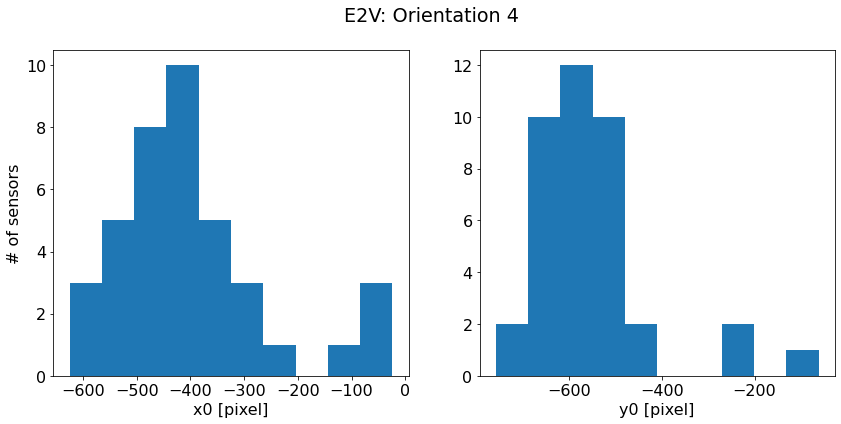

In [28]:
plot_tr_hist(D&etv_mask,'E2V: Orientation 4')

In [29]:
masks = [A,B,C,D]
orientations = [[]]

Text(0.5, 0, 'y0 [pixel]')

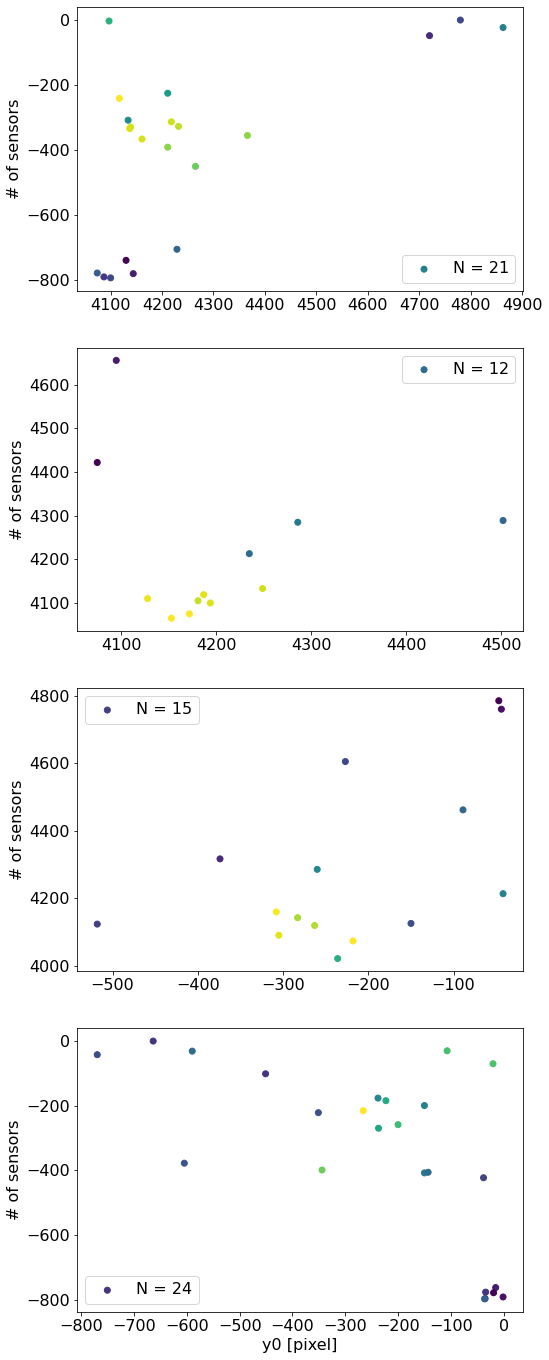

In [45]:
fig, axes = plt.subplots(4, 1, figsize=(8, 4*6))
    
for i in range(4):
    mask = itl_mask&masks[i]
    nobj = np.count_nonzero(mask)

    x0 = np.array(data[mask]['x0'])
    y0 = np.array(data[mask]['y0'])
    amp= np.log10(np.array(data[mask]['amplitude']))
    
    axes[i].scatter(x0,y0,c=amp,label=r'N = %i'%nobj)
    axes[i].legend()
    axes[i].set_ylabel('# of sensors')
    
axes[3].set_xlabel('x0 [pixel]')
axes[3].set_xlabel('y0 [pixel]')
# fig.suptitle(title)

Text(0.5, 0, 'y0 [pixel]')

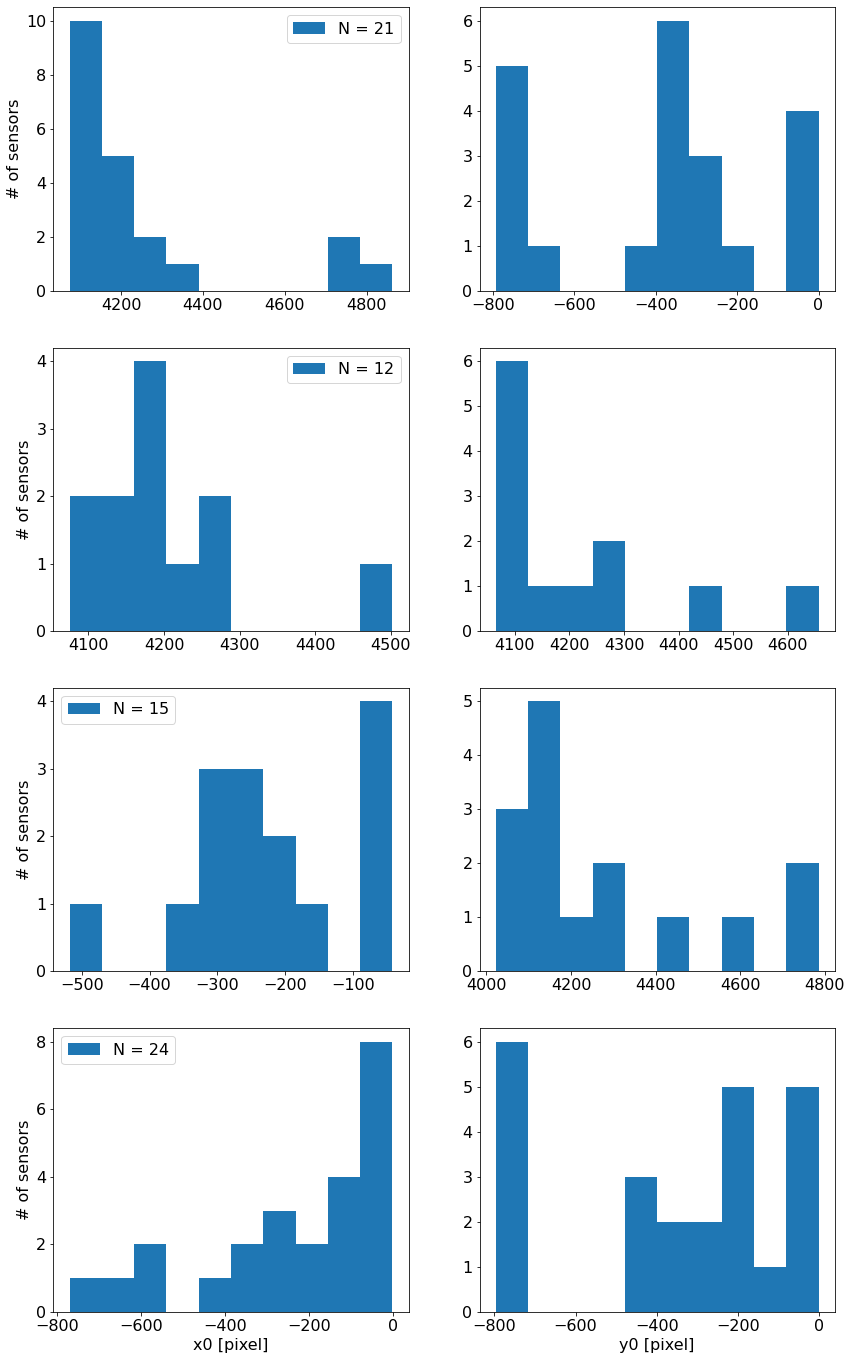

In [44]:
fig, axes = plt.subplots(4, 2, figsize=(14, 4*6))
    
for i in range(4):
    mask = itl_mask&masks[i]
    nobj = np.count_nonzero(mask)

    x0 = data[mask]['x0']
    y0 = data[mask]['y0']
    
    _ = axes[i,0].hist(x0,label=r'N = %i'%nobj)
    _ = axes[i,1].hist(y0)
    axes[i,0].legend()
    axes[i,0].set_ylabel('# of sensors')
    
axes[3,0].set_xlabel('x0 [pixel]')
axes[3,1].set_xlabel('y0 [pixel]')
# fig.suptitle(title)

In [48]:
data['amplitude']

<Column name='amplitude' dtype='float64' length=189>
0.00026
0.00014
0.00027
0.00026
0.00029
0.00015
 0.0003
0.00021
0.00031
0.00034
0.00029
0.00016
    ...
0.00037
0.00034
0.00024
0.00018
 0.0003
 0.0003
0.00018
0.00022
0.00044
0.00017
0.00045
0.00023

## Super Flats from the RTM-013/024

In [30]:
itl = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-%i_median_sflat.fits' 
itl2= '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-%i_dark_pixel_mask.fits' 
itl = itl%(205)
# itl2= itl2%(205)

image = np.rot90(make_ccd_mosaic(itl).getArray())
# mask  = np.rot90(make_ccd_mosaic(itl2).getArray())
# image[mask>0] = 0.

# etv = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-024/11318/dark_defects_raft/v0/88033/E2V-CCD250-%i_median_sflat.fits' 
# etv2= '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-024/11318/dark_defects_raft/v0/88033/E2V-CCD250-%i_dark_pixel_mask.fits' 
# etv = etv%(382)
# etv2= etv2%(382)

In [31]:
from astropy.io import fits
def get_fits(fname):
    hdulist = fits.open(fname)
    image = hdulist[1].data
    return image,hdulist

def load_image(fname,sensor='itl',overwrite=False):
    if (os.path.isfile('tmp/%s_flat.fits'%(sensor))) & (not overwrite):
        fname = 'tmp/%s_flat.fits'%(sensor)
        print('tmp: found flat field')
        print(fname)
        image, hdulist = get_fits(fname)
    else:
        image, hdulist = get_fits(fname)
        image = image#-np.median(image)
        ## save the file locally
        hdulist[1].data = image
        hdulist.writeto('tmp/%s_flat.fits'%sensor,overwrite=True)
    return image, hdulist

# ITL Tree Ring Center

In [32]:
sensor='itl'

In [33]:
# image, hdu = load_image(path+itl2,sensor='itl',overwrite=True)

# ## row flipped
# image = np.flip(image,0)

In [34]:
## Checking image shape: (4000, 4072)

image.shape

(4000, 4072)

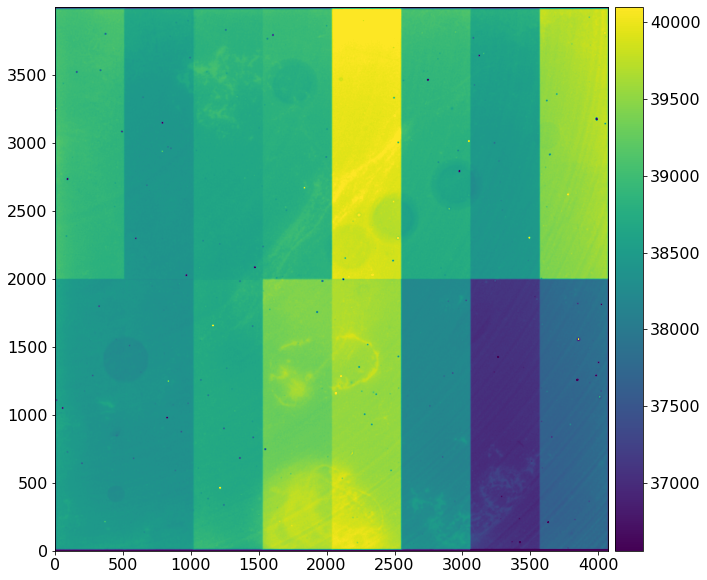

In [35]:
imshow(image)

### High Pass Filter

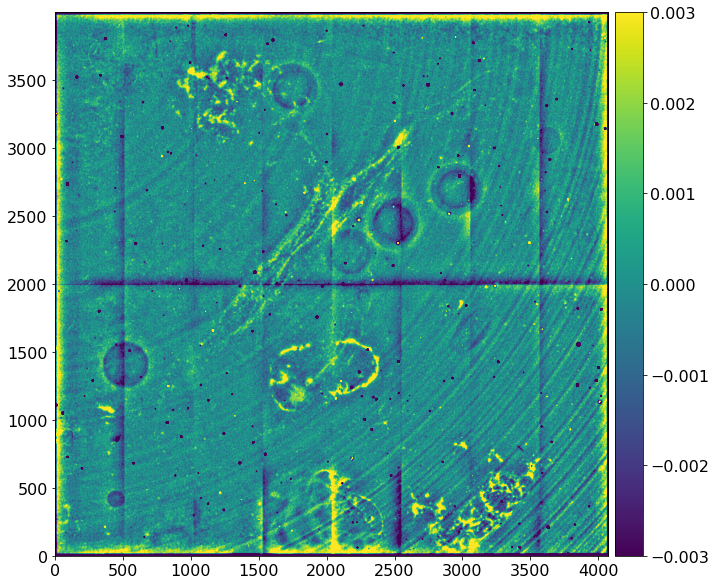

In [36]:
diff = get_diff_lowpass(image, size=250, power=4.0, use_zero=True)
imshow(diff, interpolation='bicubic',vmin=-0.003,vmax=0.003)
# plt.title('%s, detector %s' % (ref.run, ref.dataId['detector']))

In [37]:
# sensor = 'itl'
# hdu[1].data = diff
# hdu.writeto('tmp/%s_flat_diff.fits'%(sensor),overwrite=True)

In [41]:
sensor = 'ITL'

In [61]:
def get_orientation(k):
    if k==0:
        i, j, vx, vy = 1, 0, -1, +1
    if k==1:
        i, j, vx, vy = 1, 1, -1, -1
    if k==2:
        i, j, vx, vy = 0, 1, +1, -1
    if k==3:
        i, j, vx, vy = 0, 0, +1, +1
    return i, j, vx, vy

def measure_amp(v,pos,lo,hi,window):
    mids,stds = [],[]

    for _ in np.linspace(lo, hi-window, 100):
        idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
        stds.append(np.std(v[idx]))
        mids.append(np.mean(pos[idx]))

    mids = np.array(mids)
    stds = np.array(stds)
    return mids, stds

window = 500
downscale = 8
threshold = 0.0014 # For stronger rings

diff1 = gaussian_filter(diff.copy(), 8.)
mask = np.abs(diff1) > threshold #(diff1<xl)&(diff1>xh) #
diff2 = block_reduce(diff1, (downscale, downscale), func=np.nanmean)
mask2 = block_reduce(mask , (downscale, downscale), func=np.nanmax)
diff2[mask2] = np.nan

fit_info = []
for k in range(4):
    space = 800. ## pixels
    ## read the flat field file
    sensor_lims = {'e2v':[[0,4096],[0,4004]],'ITL':[[0,4072],[0,4000]]}
    i,j,vx, vy = get_orientation(k)
    spacex = vx*space
    spacey = vy*space

    ## given the image, fit the TR center
    xc, yc = sensor_lims[sensor][0][i], sensor_lims[sensor][1][j]
    xlow, xhig = np.min([xc,xc-spacex]),np.max([xc,xc-spacex])
    ylow, yhig = np.min([yc,yc-spacey]),np.max([yc,yc-spacey])

    # imshow(diff2, interpolation='bicubic', vmin=-0.003, vmax=0.003)#
    # plt.title('Downscaled and masked circle detection image')

    # Pixel coordinate grid
    y2,x2 = np.mgrid[0:diff2.shape[0], 0:diff2.shape[1]]
    y,x = np.mgrid[0:diff.shape[0], 0:diff.shape[1]]

    def fn_detect(p):
        '''Estimator to locate tree rings center in downscaled images'''
        r = np.hypot(x2-p[0], y2-p[1])
        idx = np.isfinite(diff2) & (diff2 != 0)
        v,bins,_ = binned_statistic(r[idx], diff2[idx], bins=np.arange(np.percentile(r,75), np.max(r), 1.0))
        return -np.std(v[np.isfinite(v)])

    def fn_measure(x0, y0, mask=None, step=4.0, statistic='mean'):
        '''Function to measure tree rings in original image given the center'''
        r = np.hypot(x-x0, y-y0)
        idx = np.isfinite(diff) & (diff != 0)
        if mask is not None:
            idx &= ~mask
        v,bins,_ = binned_statistic(r[idx], diff[idx], bins=np.arange(np.min(r), np.max(r), step), statistic=statistic)
        
        return 0.5*(bins[1:]+bins[:-1]), v

    cc = opt.differential_evolution(fn_detect,[[xlow/downscale,xhig/downscale],[ylow/downscale,yhig/downscale]],popsize=45)
    fit_info.append(cc)

fit_vals = np.array([cc.fun for cc in fit_info])

## find orientation
orientation = np.argmin(fit_vals)

cc = fit_info[orientation]
x0,y0 = cc.x[0]*downscale, cc.x[1]*downscale

print(cc)
print()
print("Original scale coordinates: %.2f, %.2f"%(x0, y0))

## compute TR Signal
pos,v        = fn_measure(x0, y0, mask=mask, step=1.0, statistic='mean')

lo, hi = np.percentile(pos,[25,99])

rm, amp_mean = measure_amp(v,pos,lo,hi,window)
amp_5500     = amp_mean[np.argmin(np.abs(rm-5500))]

     fun: -0.0002944335956087819
 message: 'Optimization terminated successfully.'
    nfev: 723
     nit: 7
 success: True
       x: array([-39.66611533, 511.3664859 ])

Original scale coordinates: -317.33, 4090.93


In [ ]:
def save_profile(fname):
    profile = np.stack([pos,v])
    np.save(fname,profile)

In [65]:
prof = np.stack([pos,v])

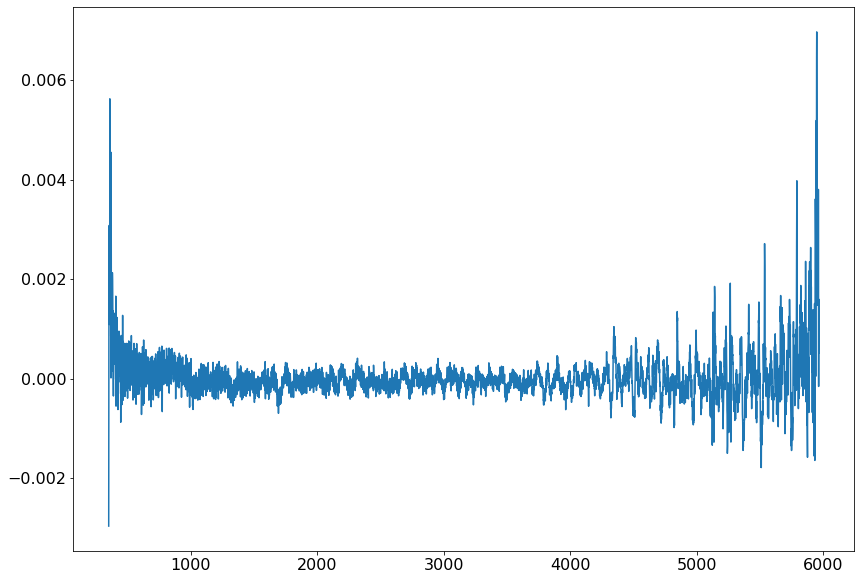

In [69]:
plt.plot(prof[0],prof[1])

In [60]:
orientation

2

In [57]:
window = 500 
rm, amp_mean = measure_amp(v,pos,lo,hi,window)
amp_5500     = amp_mean[np.argmin(np.abs(rm-5500))]

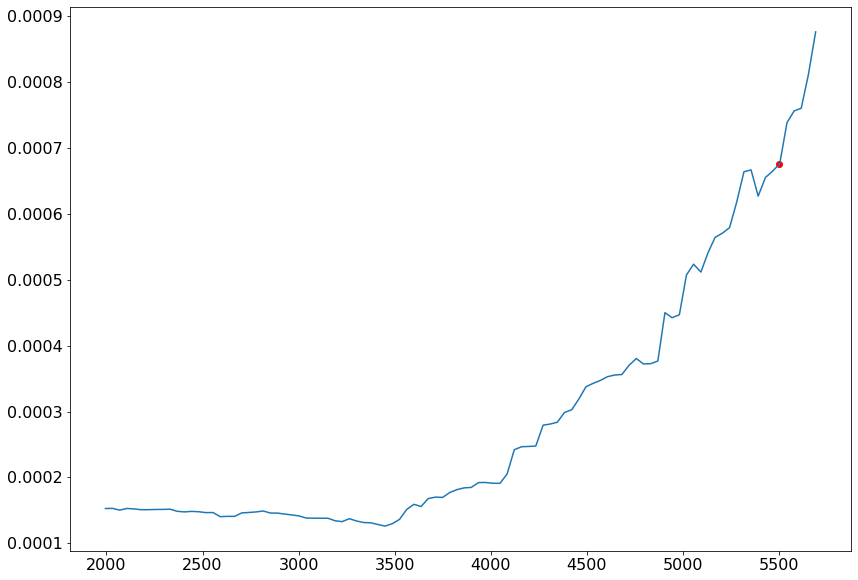

In [58]:
plt.plot(rm,amp_mean)
plt.scatter([5500],[amp_5500],color='r')

In [59]:
amp_5500

0.0006754692701613148

In [170]:
def qet_quartiles_lims(x,nsigma=1.5):
    q1,q3 = np.nanpercentile(x,[25,75])
    iqr   = 0.5*(q3-q1)
    xl,xh = q1-nsigma*iqr,q3+nsigma*iqr
    return xl, xh

In [173]:
w,     = np.where((x.flatten() > 2000.)&(y.flatten()<2000.))
xl, xh = qet_quartiles_lims(diff1.flatten()[w],nsigma=3.)

In [174]:
np.max([xl,xh])

0.0012092746255802922

## Pre-processing: smooth and masking

Text(0.5, 1.0, 'Downscaled and masked circle detection image')

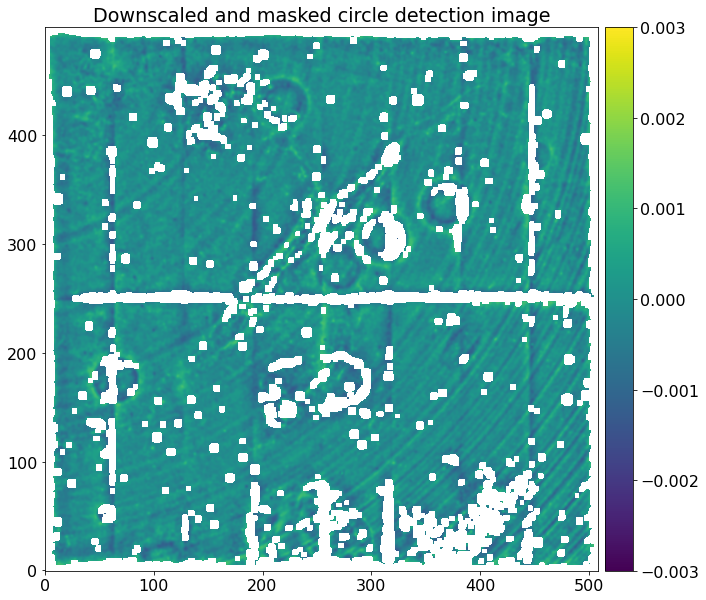

In [175]:
downscale = 8
# threshold = 0.0003 # For faintest rings
# threshold = 0.0005 # For faint rings
threshold = 0.0014 # For stronger rings
# threshold = 0.003 # For strongest rings
# threshold = np.max([xl,xh])

diff1 = gaussian_filter(diff.copy(), 8.)
mask = np.abs(diff1) > threshold #(diff1<xl)&(diff1>xh) #
diff2 = block_reduce(diff1, (downscale, downscale), func=np.nanmean)
mask2 = block_reduce(mask , (downscale, downscale), func=np.nanmax)
diff2[mask2] = np.nan

imshow(diff2, interpolation='bicubic', vmin=-0.003, vmax=0.003)#
plt.title('Downscaled and masked circle detection image')

### Finding the TR Center

In [150]:
# Pixel coordinate grid
y2,x2 = np.mgrid[0:diff2.shape[0], 0:diff2.shape[1]]
y,x = np.mgrid[0:diff.shape[0], 0:diff.shape[1]]

def fn_detect(p):
    '''Estimator to locate tree rings center in downscaled images'''
    r = np.hypot(x2-p[0], y2-p[1])
    idx = np.isfinite(diff2) & (diff2 != 0)
    v,bins,_ = binned_statistic(r[idx], diff2[idx], bins=np.arange(np.percentile(r,75), np.max(r), 1.0))
    return -np.std(v[np.isfinite(v)])

def fn_measure(x0, y0, mask=None, step=4.0, statistic='mean'):
    '''Function to measure tree rings in original image given the center'''
    r = np.hypot(x-x0, y-y0)
    idx = np.isfinite(diff) & (diff != 0)
    if mask is not None:
        idx &= ~mask
    v,bins,_ = binned_statistic(r[idx], diff[idx], bins=np.arange(np.min(r), np.max(r), step), statistic=statistic)
    
    return 0.5*(bins[1:]+bins[:-1]), v

In [182]:
xlow, xhig = -800., 0.
ylow, yhig = 4000., 4800.

ylow, yhig = -800., 0.

cc = opt.differential_evolution(fn_detect,[[xlow/downscale,xhig/downscale],[ylow/downscale,yhig/downscale]])
print(cc)

x0,y0 = cc.x[0]*downscale, cc.x[1]*downscale
print()
print("Original scale coordinates: %.2f, %.2f"%(x0, y0))

     fun: -0.00017057961378675102
 message: 'Optimization terminated successfully.'
    nfev: 303
     nit: 9
 success: True
       x: array([ -2.52946967, -94.04316012])

Original scale coordinates: -20.24, -752.35


In [184]:
cc.fun

-0.00017057961378675102

In [152]:
## x0,y0 = -335.49, 4095.84
## std=0.00017528

### Diagnostic Plots

Text(0.5, 1.0, '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/LCA-11021_RTM-013/10982/dark_defects_raft/v0/85196/ITL-3800C-205_dark_pixel_mask.fits')

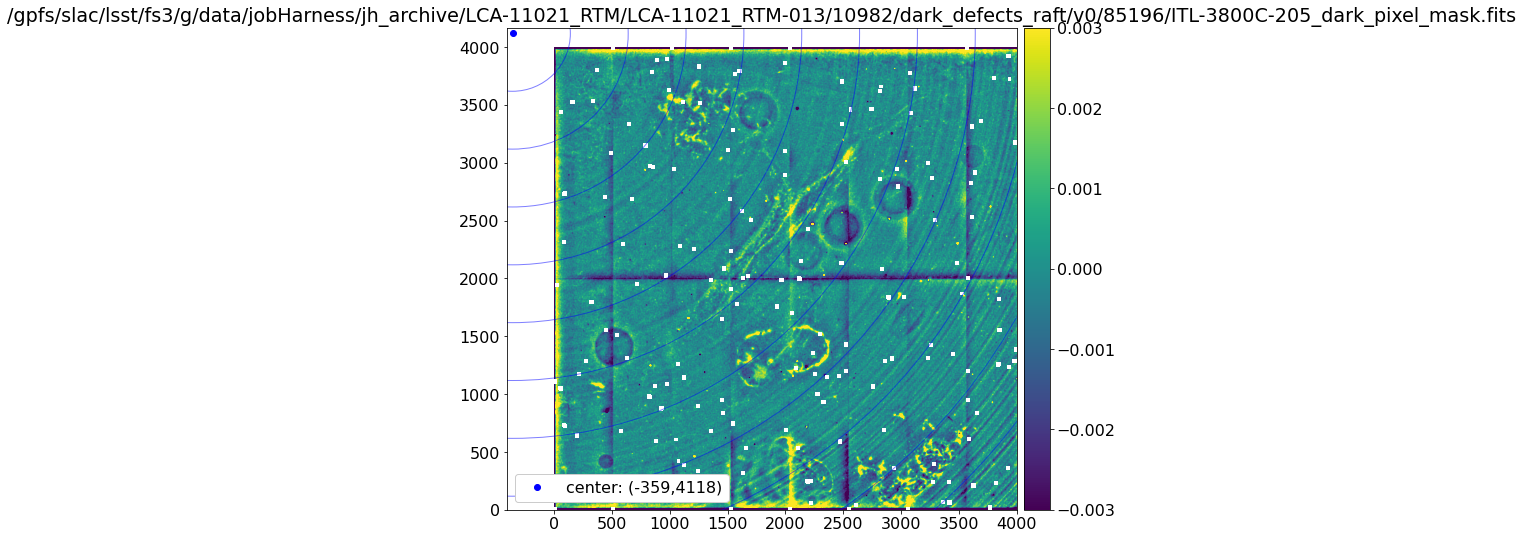

In [153]:
from matplotlib.patches import Circle

plt.figure(figsize=(10,12))

plt.subplot2grid((4,1),(0,0), rowspan=3)

imshow(diff, vmin=-0.003, vmax=0.003)
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

plt.plot(x0, y0, 'o', color='blue', label="center: (%.0f,%.0f)" % (x0, y0))

# plt.text(x0+30, y0+30, "(%.0f,%.0f)" % (x0, y0))
plt.legend(frameon=True, framealpha=1)

for _ in np.arange(0, 6000, 500):
    plt.gca().add_patch(Circle((x0, y0), _, color='blue', ls='-', fc='none', alpha=0.5))

# plt.xlim(x0-50,4200)
# plt.ylim(-50,y0+50)

plt.xlim(x0-50,4000)
plt.ylim(0., y0+50)

# plt.xlim(x0-50,4000)
# plt.ylim(y0-50, 4000.)

# plt.show()

plt.title(itl2)


(1795.549395878028, 6075.049395878028)

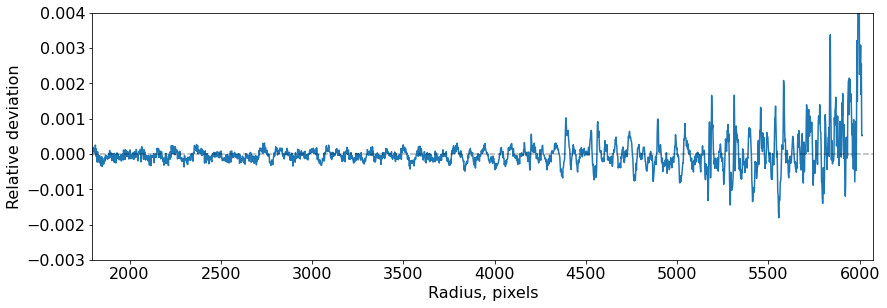

In [157]:
pos,v = fn_measure(x0, y0, mask=mask, step=2.0, statistic='mean')

plt.subplot(211)
plt.plot(pos, v, '-')
plt.axhline(0, color='black', alpha=0.3, ls='--')
plt.xlabel('Radius, pixels')
plt.ylabel('Relative deviation')
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.003, 0.004)
plt.xlim(np.percentile(pos,25),np.max(pos)+30)

Will analyse the following radial interval: 4611 - 5789 pixels


<ipython-input-158-89febf241e61>:19: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1.0/freq, power, '-')


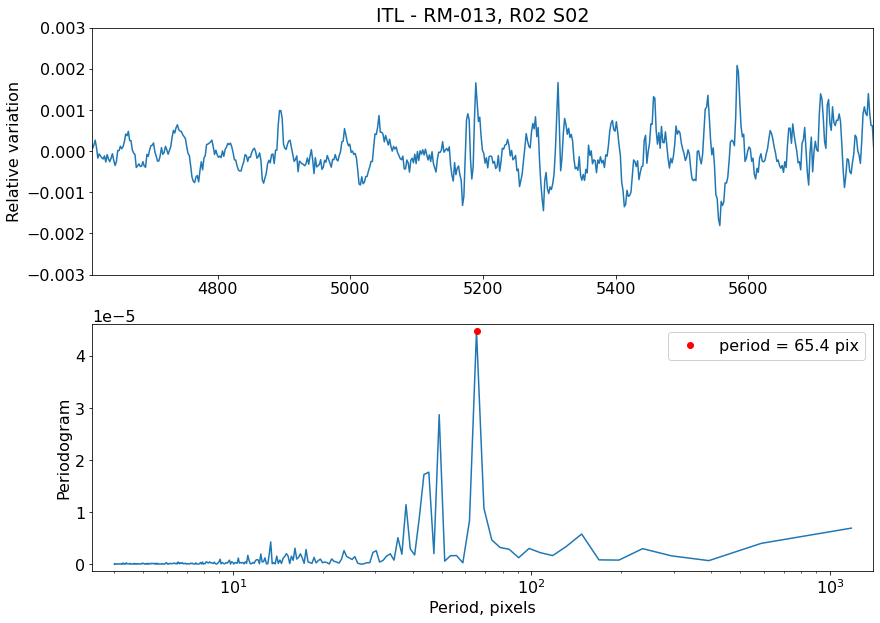

In [158]:
from scipy.signal import periodogram, lombscargle

lo,hi = np.percentile(pos[np.isfinite(v)], [75,96])
print("Will analyse the following radial interval: %.0f - %.0f pixels" % (lo,hi))
idx = np.isfinite(v) & (pos > lo) & (pos < hi)

freq,power = periodogram(v[idx], fs=1.0/(pos[1]-pos[0]))

plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylim(-0.003,0.003)
plt.ylabel('Relative variation')
plt.title('ITL - RM-013, R02 S02')

#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

plt.subplot(212)
plt.plot(1.0/freq, power, '-')
maxidx = power==np.max(power[freq>1e-3])
plt.plot(1.0/freq[maxidx], power[maxidx], 'o', color='red', label="period = %.1f pix" % (1.0/freq[maxidx][0]))
plt.legend(frameon=True, framealpha=0.9)

plt.xscale('log')
plt.xlabel('Period, pixels')
plt.ylabel('Periodogram')
# plt.xlim(1e-3,1e-1)
plt.margins(0.03, 0.03)

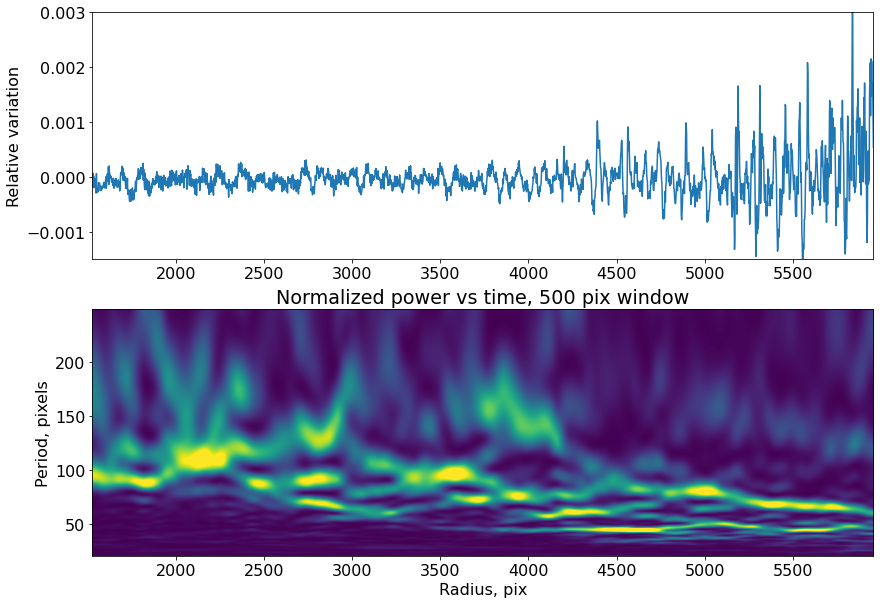

In [160]:
normalize = True

dynpower = []
window = 500
lo,hi = np.percentile(pos[np.isfinite(v)], [20,99])
periods = np.arange(20.0, 250.0, 0.1)

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    power = lombscargle(pos[idx], v[idx], 2*np.pi/periods, normalize=normalize, precenter=False)
    dynpower.append(power)
    
dynpower = np.array(dynpower).T
extent = [lo,hi,periods[0],periods[-1]]

ax=plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.0015,0.0030)

plt.subplot(212, sharex=ax)
imshow(dynpower, [0.5, 99.0], aspect='auto', extent=extent, interpolation='bicubic', show_colorbar=False)
plt.xlabel('Radius, pix')
plt.ylabel('Period, pixels')
if normalize:
    plt.title('Normalized power vs time, %g pix window' % window)
else:
    plt.title('Unnormalized power vs time, %g pix window' % window)
# plt.yscale('log')


<ipython-input-161-deb69ba41938>:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')


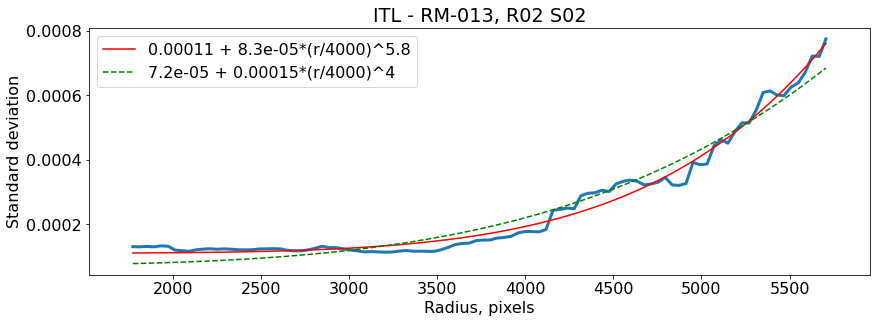

In [161]:
#lo = 3000
mids,stds = [],[]

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    stds.append(np.std(v[idx]))
    mids.append(np.mean(pos[idx]))

mids = np.array(mids)
stds = np.array(stds)

ax=plt.subplot(211)
plt.plot(mids, stds, lw=3, alpha=1)
plt.xlim(lo,hi)
plt.xlabel('Radius, pixels')
plt.ylabel('Standard deviation')
plt.title('ITL - RM-013, R02 S02')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

def fn(p):
    return p[0] + p[1]*(mids/4000)**p[2] - stds

def fn4(p):
    return p[0] + p[1]*(mids/4000)**4 - stds

p,_ = opt.leastsq(fn, [0.0, 1e-4, 4.0])
plt.plot(mids, p[0] + p[1]*(mids/4000)**p[2], '-', color='red', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], p[2]))

p,_ = opt.leastsq(fn4, [0.0, 1e-4])
plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')

plt.legend(frameon=True)

# E2V Tree Ring Center

In [79]:
image, hdu = load_image(path+etv2,sensor='e2v',overwrite=True)

## row flipped
image = np.flip(image,0)

In [80]:
## Checking image shape: (4004, 4096)

image.shape

(4004, 4096)

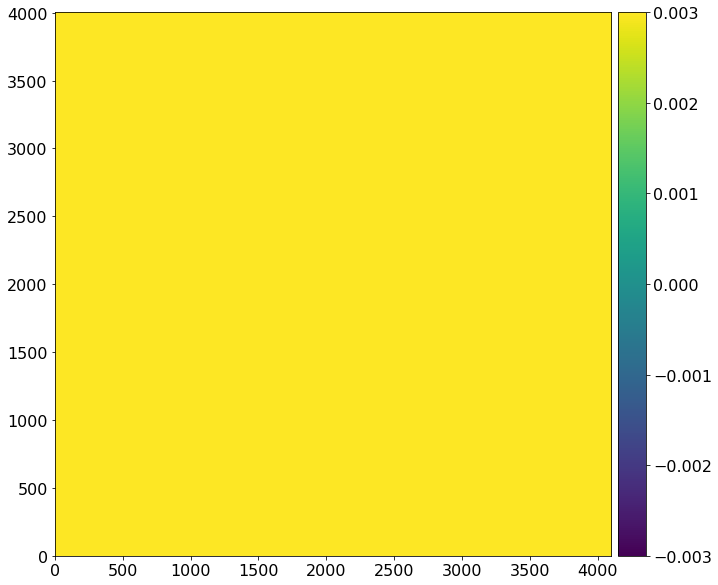

In [81]:
imshow(image,vmin=-0.003,vmax=0.003)

### High Pass Filter

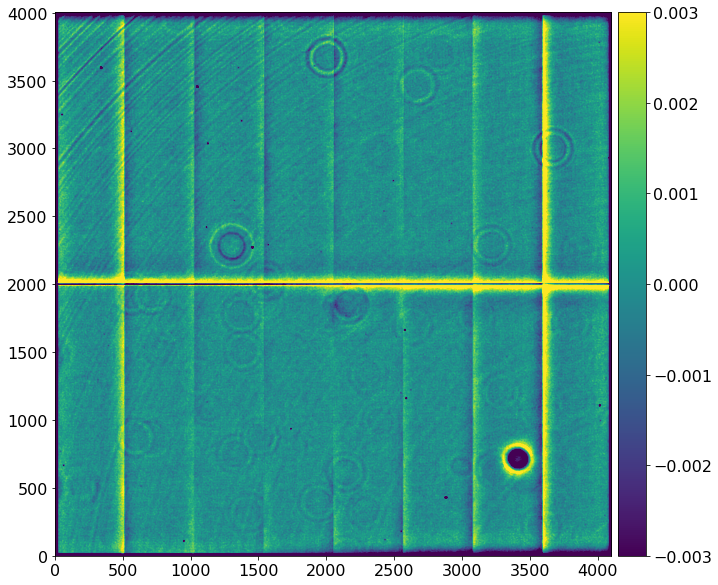

In [82]:
diff = get_diff_lowpass(image, size=250, power=4.0, use_zero=True)
imshow(diff, interpolation='bicubic',vmin=-0.003,vmax=0.003)
# plt.title('%s, detector %s' % (ref.run, ref.dataId['detector']))

In [83]:
sensor = 'e2v'
hdu[1].data = diff
hdu.writeto('tmp/%s_flat_diff.fits'%(sensor),overwrite=True)

## Pre-processing: smooth and masking

Text(0.5, 1.0, 'Downscaled and masked circle detection image')

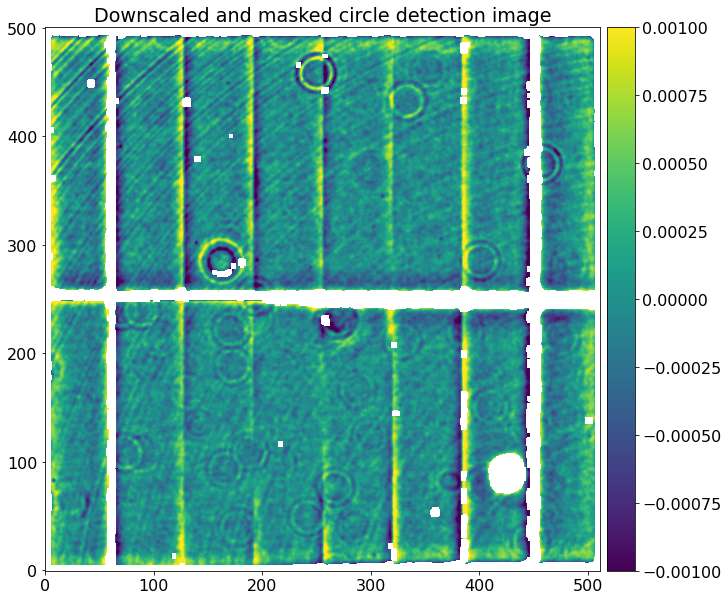

In [84]:
downscale = 8
# threshold = 0.0003 # For faintest rings
# threshold = 0.0005 # For faint rings
threshold = 0.002 # For stronger rings
threshold = 0.0015 # For strongest rings

diff1 = gaussian_filter(diff.copy(), 8.)
mask = np.abs(diff1) > threshold
diff2 = block_reduce(diff1, (downscale, downscale), func=np.nanmean)
mask2 = block_reduce(mask, (downscale, downscale), func=np.nanmax)
diff2[mask2] = None

imshow(diff2, interpolation='bicubic', vmin=-0.001, vmax=0.001)#
plt.title('Downscaled and masked circle detection image')

### Finding the TR Center

In [38]:
# Pixel coordinate grid
y2,x2 = np.mgrid[0:diff2.shape[0], 0:diff2.shape[1]]
y,x   = np.mgrid[0:diff.shape[0], 0:diff.shape[1]]

In [39]:
ylow, yhig = -1000., 0.
xlow, xhig = 4000., 5000.

cc = opt.differential_evolution(fn_detect,[[xlow/downscale,xhig/downscale],[ylow/downscale,yhig/downscale]], popsize=40)
print(cc)

x0,y0 = cc.x[0]*downscale, cc.x[1]*downscale
print()
print("Original scale coordinates: %.2f, %.2f"%(x0, y0))

     fun: -0.00015791721698963566
 message: 'Optimization terminated successfully.'
    nfev: 963
     nit: 11
 success: True
       x: array([583.39646033, -84.80209029])

Original scale coordinates: 4667.17, -678.42


In [31]:
# x0, y0, std = 4627.47, -630.89, 0.00014681
# x0, y0 =4667, -678

### Diagnostic Plots

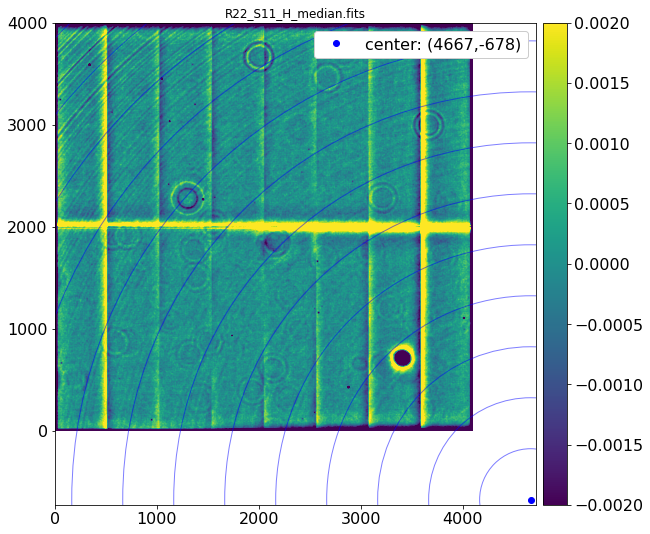

In [40]:
from matplotlib.patches import Circle

plt.figure(figsize=(10,12))

plt.subplot2grid((4,1),(0,0), rowspan=3)

imshow(diff, vmin=-0.002, vmax=0.002)
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

plt.plot(x0, y0, 'o', color='blue', label="center: (%.0f,%.0f)" % (x0, y0))

# plt.text(x0+30, y0+30, "(%.0f,%.0f)" % (x0, y0))
plt.legend(frameon=True, framealpha=1)

for _ in np.arange(0, 7000, 500):
    plt.gca().add_patch(Circle((x0, y0), _, color='blue', ls='-', fc='none', alpha=0.5))

# plt.xlim(x0-50,4200)
# plt.ylim(-50,y0+50)

plt.ylim(y0-50,4000)
plt.xlim(0., x0+50)

plt.title('R22_S11_H_median.fits',fontsize=12)
# plt.show()

# Now make less restrictive mask
# mask = np.abs(diff1) > 0.002

pos,v = fn_measure(x0, y0, mask=mask, step=1.0, statistic='mean')
# plt.subplot(211)
# plt.subplot2grid((4,1),(3,0), rowspan=1)

# plt.plot(pos, v, '-')
# plt.axhline(0, color='black', alpha=0.3, ls='--')
# plt.xlabel('Radius, pixels')
# plt.ylabel('Relative deviation')
# # plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
# plt.ylim(-0.002, 0.002)
# plt.tight_layout()

(5100.0, 6831.735032845024)

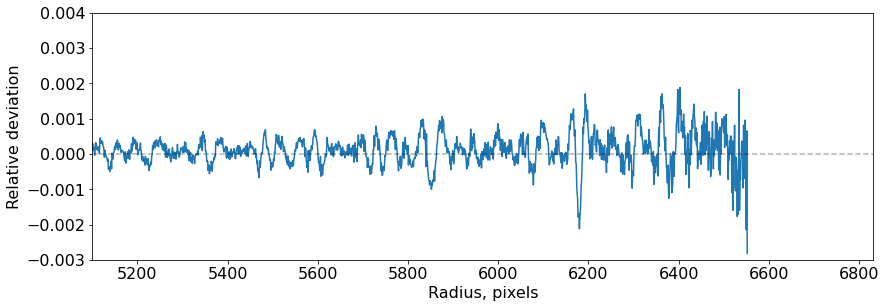

In [41]:
plt.subplot(211)
plt.plot(pos, v, '-')
plt.axhline(0, color='black', alpha=0.3, ls='--')
plt.xlabel('Radius, pixels')
plt.ylabel('Relative deviation')
# plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.003, 0.004)
plt.xlim(5100,)

Will analyse the following radial interval: 2076 - 6328 pixels


<ipython-input-42-42fb409ea4f5>:17: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1.0/freq, power, '-')


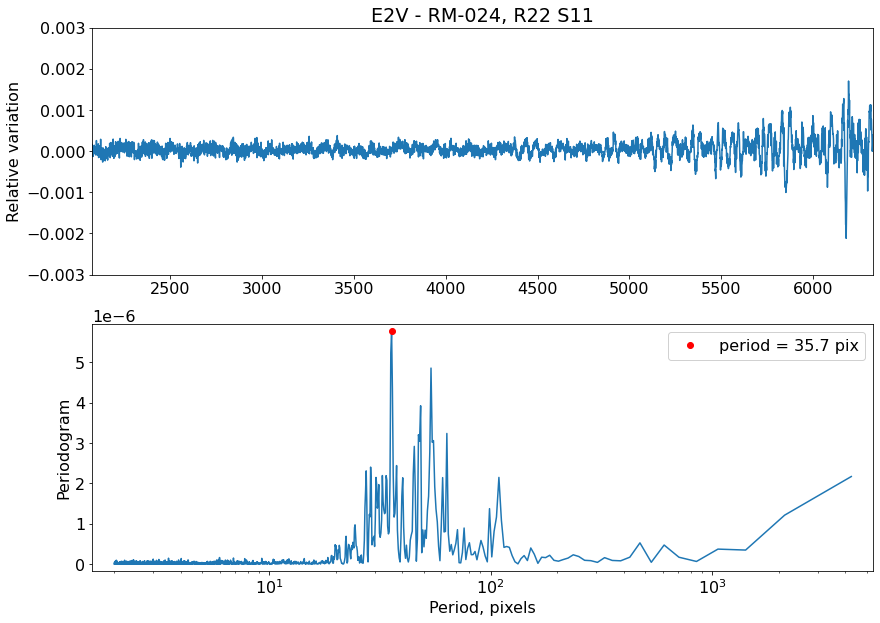

In [42]:
from scipy.signal import periodogram, lombscargle

lo,hi = np.percentile(pos[np.isfinite(v)], [20,96])
print("Will analyse the following radial interval: %.0f - %.0f pixels" % (lo,hi))
idx = np.isfinite(v) & (pos > lo) & (pos < hi)

freq,power = periodogram(v[idx], fs=1.0/(pos[1]-pos[0]))

plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
plt.ylim(-0.003, 0.003)
plt.title('E2V - RM-024, R22 S11')

plt.subplot(212)
plt.plot(1.0/freq, power, '-')
maxidx = power==np.max(power[freq>1e-3])
plt.plot(1.0/freq[maxidx], power[maxidx], 'o', color='red', label="period = %.1f pix" % (1.0/freq[maxidx][0]))
plt.legend(frameon=True, framealpha=0.9)

plt.xscale('log')
plt.xlabel('Period, pixels')
plt.ylabel('Periodogram')
# plt.xlim(1e-3,1e-1)
plt.margins(0.03, 0.03)

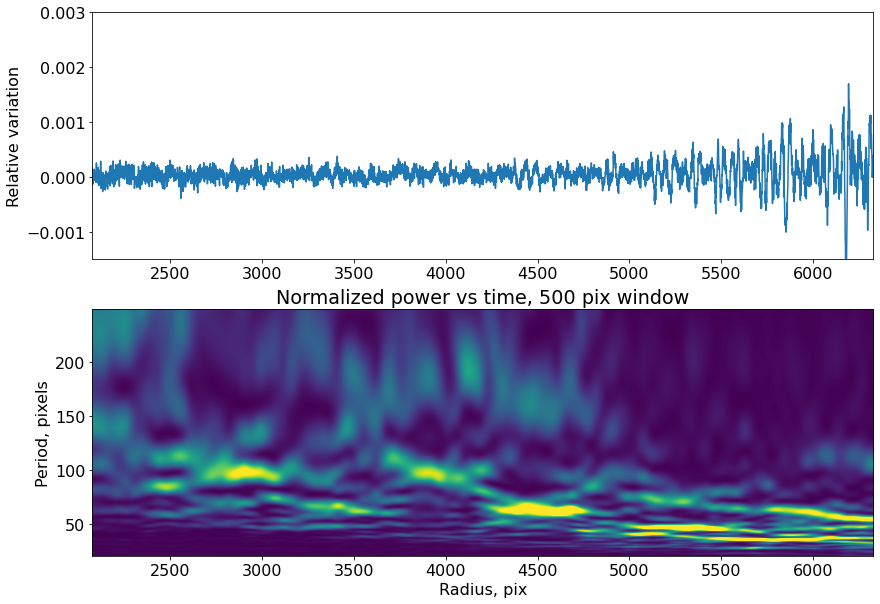

In [43]:
normalize = True

dynpower = []
window = 500
lo,hi = np.percentile(pos[np.isfinite(v)], [20,96])
periods = np.arange(20.0, 250.0, 0.1)

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    power = lombscargle(pos[idx], v[idx], 2*np.pi/periods, normalize=normalize, precenter=False)
    dynpower.append(power)
    
dynpower = np.array(dynpower).T
extent = [lo,hi,periods[0],periods[-1]]

ax=plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.0015,0.0030)

plt.subplot(212, sharex=ax)
imshow(dynpower, [0.5, 99.0], aspect='auto', extent=extent, interpolation='bicubic', show_colorbar=False)
plt.xlabel('Radius, pix')
plt.ylabel('Period, pixels')
if normalize:
    plt.title('Normalized power vs time, %g pix window' % window)
else:
    plt.title('Unnormalized power vs time, %g pix window' % window)
# plt.yscale('log')


<ipython-input-44-57fd0f3833f5>:31: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')


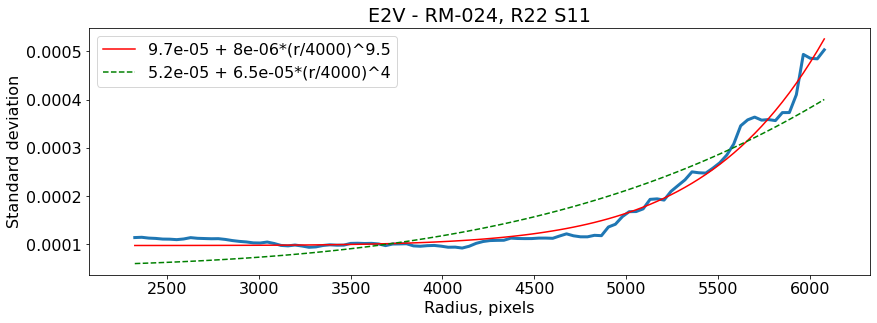

In [44]:
#lo = 3000
mids,stds = [],[]

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    stds.append(np.std(v[idx]))
    mids.append(np.mean(pos[idx]))

mids = np.array(mids)
stds = np.array(stds)

ax=plt.subplot(211)
plt.plot(mids, stds, lw=3, alpha=1)
plt.xlim(lo,hi)
plt.xlabel('Radius, pixels')
plt.ylabel('Standard deviation')
plt.title('E2V - RM-024, R22 S11')

#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))

def fn(p):
    return p[0] + p[1]*(mids/4000)**p[2] - stds

def fn4(p):
    return p[0] + p[1]*(mids/4000)**4 - stds

p,_ = opt.leastsq(fn, [0.0, 1e-4, 4.0])
plt.plot(mids, p[0] + p[1]*(mids/4000)**p[2], '-', color='red', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], p[2]))

p,_ = opt.leastsq(fn4, [0.0, 1e-4])
plt.plot(mids, p[0] + p[1]*(mids/4000)**4, '-', color='green', label="%.2g + %.2g*(r/4000)^%.2g" % (p[0], p[1], 4.0), ls='--')

plt.legend(frameon=True)